In [1]:
# from __future__ import print_function, division, absolute_import, unicode_literals
%matplotlib inline
import os
import shutil
import numpy as np
from collections import OrderedDict
import logging
import nrrd
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import matplotlib.pylab as plt
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(message)s')

In [2]:
from PIL import Image

def plot_prediction(x_test, y_test, prediction, save=False):
    import matplotlib
    import matplotlib.pyplot as plt
    
    test_size = x_test.shape[0]
    fig, ax = plt.subplots(test_size, 3, figsize=(12,12), sharey=True, sharex=True)
    
    x_test = crop_to_shape(x_test, prediction.shape)
    y_test = crop_to_shape(y_test, prediction.shape)
    
    ax = np.atleast_3d(ax)
    for i in range(test_size):
        cax = ax[i, 0].imshow(x_test[i])
        plt.colorbar(cax, ax=ax[i,0])
        cax = ax[i, 1].imshow(y_test[i, ..., 1])
        plt.colorbar(cax, ax=ax[i,1])
        pred = prediction[i, ..., 1]
        pred -= np.amin(pred)
        pred /= np.amax(pred)
        cax = ax[i, 2].imshow(pred)
        plt.colorbar(cax, ax=ax[i,2])
        if i==0:
            ax[i, 0].set_title("x")
            ax[i, 1].set_title("y")
            ax[i, 2].set_title("pred")
    fig.tight_layout()
    
    if save:
        fig.savefig(save)
    else:
        fig.show()
        plt.show()


def crop_to_shape(data, shape):
    """
    Crops the array to the given image shape by removing the border (expects a tensor of shape [batches, nx, ny, nz, channels].
    
    :param data: the array to crop
    :param shape: the target shape
    """
    offset0 = (data.shape[1] - shape[1])//2
    offset1 = (data.shape[2] - shape[2])//2
    offset2 = (data.shape[3] - shape[3])//2
    out = data[:, offset0:offset0+shape[1], offset1:offset1+shape[2], offset2:offset2+shape[3]]
    return out


def weight_variable(shape, stddev=0.1):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial)

def weight_variable_devonc(shape, stddev=0.1):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev))

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv3d(x, W,keep_prob_):
    conv_3d = tf.nn.conv3d(x, W, strides=[1, 1, 1, 1, 1], padding='VALID')
    return tf.nn.dropout(conv_3d, keep_prob_)
#     return conv_3d

def deconv3d(x, W, stride=1):
    x_shape = tf.shape(x)
#     print(x.get_shape())
    output_shape = tf.stack([x_shape[0], x_shape[1] * 2, x_shape[2] * 2, x_shape[3] * 2, x_shape[4] // 2])
#     print(output_shape.get_shape())
#     print(W.get_shape())
    return tf.nn.conv3d_transpose(x, W, output_shape, strides=[1, stride, stride, stride, 1], padding='VALID')

def max_pool(x,n):
    return tf.nn.max_pool3d(x, ksize=[1, n, n, n, 1], strides=[1, n, n, n, 1], padding='VALID')

def crop_and_concat(x1,x2):
    x1_shape = tf.shape(x1)
    x2_shape = tf.shape(x2)
    # offsets for the top left corner of the crop
    offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2,  (x1_shape[3] - x2_shape[3]) // 2, 0]
    size = [-1, x2_shape[1], x2_shape[2], x2_shape[3], -1]
    x1_crop = tf.slice(x1, offsets, size)
    print(x1_crop.get_shape(), x2.get_shape())
    return tf.concat([x1_crop, x2], 4)

def pixel_wise_softmax(output_map):
    exponential_map = tf.exp(output_map)
    evidence = tf.add(exponential_map,tf.reverse(exponential_map,[False,False,False,True]))
    return tf.div(exponential_map,evidence, name="pixel_wise_softmax")

def pixel_wise_softmax_2(output_map):
    exponential_map = tf.exp(output_map)
    sum_exp = tf.reduce_sum(exponential_map, 4, keep_dims=True)
    tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, 1, tf.shape(output_map)[4]]))
    return tf.div(exponential_map,tensor_sum_exp)

def cross_entropy(y_,output_map):
    return -tf.reduce_mean(y_*tf.log(tf.clip_by_value(output_map,1e-10,1.0)), name="cross_entropy")
#     return tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(output_map), reduction_indices=[1]))

In [3]:
def create_conv_net(x, keep_prob, channels, n_class, layers=3, features_root=16, filter_size=3, pool_size=2, summaries=True):
    """
    Creates a new convolutional unet for the given parametrization.
    
    :param x: input tensor, shape [?,nx,ny,nz,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """
    
    logging.info("Layers {layers}, features {features}, filter size {filter_size}x{filter_size}, pool size: {pool_size}x{pool_size}".format(layers=layers,
                                                                                                           features=features_root,
                                                                                                           filter_size=filter_size,
                                                                                                           pool_size=pool_size))
    # Placeholder for the input image
    nx = tf.shape(x)[1]
    ny = tf.shape(x)[2]
    nz = tf.shape(x)[3]
    x_image = tf.reshape(x, tf.stack([-1,nx,ny,nz,channels]), name='input_reshape')
    in_node = x_image
    batch_size = tf.shape(x_image)[0]
 
    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()
    
    in_size = 1000
    size = in_size
    # down layers
    with tf.name_scope('going_down'):
        for layer in range(0, layers):
            with tf.name_scope('layer_down_%d'%layer):
                features = 2**layer*features_root
                stddev = np.sqrt(2 / (filter_size**2 * features))
                if layer == 0:
                    w1 = weight_variable([filter_size, filter_size, filter_size, channels, features], stddev)
                else:
                    w1 = weight_variable([filter_size, filter_size, filter_size, features//2, features], stddev)

                w2 = weight_variable([filter_size, filter_size, filter_size, features, features], stddev)
                b1 = bias_variable([features])
                b2 = bias_variable([features])

                conv1 = conv3d(in_node, w1, keep_prob)
                tmp_h_conv = tf.nn.elu(conv1 + b1)
                conv2 = conv3d(tmp_h_conv, w2, keep_prob)
                dw_h_convs[layer] = tf.nn.elu(conv2 + b2)

                weights.append((w1, w2))
                biases.append((b1, b2))
                convs.append((conv1, conv2))

                size -= 4
                if layer < layers-1:
                    pools[layer] = max_pool(dw_h_convs[layer], pool_size)
                    in_node = pools[layer]
                    size /= 2
        
    in_node = dw_h_convs[layers-1]
        
    # up layers
    with tf.name_scope('going_up'):
        for layer in range(layers-2, -1, -1):
            with tf.name_scope('layer_up_%d'%layer):
                features = 2**(layer+1)*features_root
                stddev = np.sqrt(2 / (filter_size**2 * features))

                wd = weight_variable_devonc([pool_size, pool_size, pool_size, features//2, features], stddev)
                bd = bias_variable([features//2])
                h_deconv = tf.nn.elu(deconv3d(in_node, wd, pool_size) + bd)
                h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)
                deconv[layer] = h_deconv_concat

                w1 = weight_variable([filter_size, filter_size, filter_size, features, features//2], stddev)
                w2 = weight_variable([filter_size, filter_size, filter_size, features//2, features//2], stddev)
                b1 = bias_variable([features//2])
                b2 = bias_variable([features//2])

                conv1 = conv3d(h_deconv_concat, w1, keep_prob)
                h_conv = tf.nn.elu(conv1 + b1)
                conv2 = conv3d(h_conv, w2, keep_prob)
                in_node = tf.nn.elu(conv2 + b2)
                up_h_convs[layer] = in_node

                weights.append((w1, w2))
                biases.append((b1, b2))
                convs.append((conv1, conv2))

                size *= 2
                size -= 4

    # Output Map
    with tf.name_scope('output_map'):
        weight = weight_variable([1, 1, 1, features_root, n_class], stddev)
        bias = bias_variable([n_class])
        conv = conv3d(in_node, weight, tf.constant(1.0))
        output_map = tf.nn.elu(conv + bias)
        up_h_convs["out"] = output_map

        if summaries:
    #         for i, (c1, c2) in enumerate(convs):
    #             tf.summary.image('summary_conv_%03d_01'%i, get_image_summary(c1))
    #             tf.summary.image('summary_conv_%03d_02'%i, get_image_summary(c2))

    #         for k in pools.keys():
    #             tf.summary.image('summary_pool_%03d'%k, get_image_summary(pools[k]))

    #         for k in deconv.keys():
    #             tf.summary.image('summary_deconv_concat_%03d'%k, get_image_summary(deconv[k]))

            for k in dw_h_convs.keys():
                tf.summary.histogram("dw_convolution_%03d"%k + '/activations', dw_h_convs[k])

            for k in up_h_convs.keys():
                tf.summary.histogram("up_convolution_%s"%k + '/activations', up_h_convs[k])

        variables = []
        for w1,w2 in weights:
            variables.append(w1)
            variables.append(w2)

        for b1,b2 in biases:
            variables.append(b1)
            variables.append(b2)

    
    return output_map, variables, int(in_size - size)


class Unet(object):
    """
    A unet implementation
    
    :param channels: (optional) number of channels in the input image
    :param n_class: (optional) number of output labels
    :param cost: (optional) name of the cost function. Default is 'cross_entropy'
    :param cost_kwargs: (optional) kwargs passed to the cost function. See Unet._get_cost for more options
    """
    
    def __init__(self, channels=1, n_class=2, cost="dice_coefficient", cost_kwargs={}, **kwargs):
        tf.reset_default_graph()
        
        self.n_class = n_class
        self.summaries = kwargs.get("summaries", True)
        
        self.x = tf.placeholder("float", shape=[None, None, None, None, channels], name='data')
        self.y = tf.placeholder("float", shape=[None, None, None, None,  n_class], name='target')
        self.keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
        
        logits, self.variables, self.offset = create_conv_net(self.x, self.keep_prob, channels, n_class, **kwargs)
        logging.info(logits.get_shape())
        logging.info(self.y.get_shape())
        
        self.cost = self._get_cost(logits, cost, cost_kwargs)
        
        self.gradients_node = tf.gradients(self.cost, self.variables)
         
        self.cross_entropy = tf.reduce_mean(cross_entropy(tf.reshape(self.y, [-1, n_class], name='cross_entro_label_reshape'),
                                                          tf.reshape(pixel_wise_softmax_2(logits), [-1, n_class], name='px_logit_reshape')))
        
#         self.predicter = pixel_wise_softmax_2(logits)
        self.predicter = tf.nn.softmax(logits)
#         self.correct_pred = tf.equal(tf.(self.predicter, 4), tf.argmax(self.y, 4))
        self.correct_pred = tf.equal(self.predicter>0.5, self.y>0.5)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        
    def _get_cost(self, logits, cost_name, cost_kwargs):
        """
        Constructs the cost function, either cross_entropy, weighted cross_entropy or dice_coefficient.
        Optional arguments are: 
        class_weights: weights for the different classes in case of multi-class imbalance
        regularizer: power of the L2 regularizers added to the loss function
        """
        with tf.name_scope('cost_function'):
            logging.info('*'*50)
            logging.info('getting cost')
            logging.info(logits.get_shape())
            logging.info(self.y.get_shape())
            flat_logits = tf.reshape(logits, [-1, self.n_class], name='flat_logits_reshape')
            flat_labels = tf.reshape(self.y, [-1, self.n_class], name='flat_labels_reshape')
            if cost_name == "cross_entropy":
                class_weights = cost_kwargs.pop("class_weights", None)

                if class_weights is not None:
                    class_weights = tf.constant(np.array(class_weights, dtype=np.float32))

                    weight_map = tf.multiply(flat_labels, class_weights, name='weightmap')
                    weight_map = tf.reduce_sum(weight_map, axis=1)

                    loss_map = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, labels=flat_labels)
                    weighted_loss = tf.multiply(loss_map, weight_map, name='weightloss')

                    loss = tf.reduce_mean(weighted_loss)

                else:
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, 
                                                                                  labels=flat_labels))
            elif cost_name == "dice_coefficient":
                intersection = tf.reduce_sum(flat_logits * flat_labels, axis=1, keep_dims=True)
                mulLogits = tf.multiply(flat_logits, flat_logits, name='dicecoeff_logits_mul')
                mulLabels = tf.multiply(flat_labels, flat_labels, name='dicecoeff_labels_mul')
                union = tf.reduce_sum(mulLogits, axis=1, keep_dims=True) + tf.reduce_sum(mulLabels, axis=1, keep_dims=True)
                loss = 1 - tf.reduce_mean(2 * intersection/ (union))

            else:
                raise ValueError("Unknown cost function: "%cost_name)

            regularizer = cost_kwargs.pop("regularizer", None)
            if regularizer is not None:
                regularizers = sum([tf.nn.l2_loss(variable) for variable in self.variables])
                loss += (regularizer * regularizers)
            
        return loss

    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data
        
        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, nz, channels]
        :returns prediction: The unet prediction Shape [n, px, py, pz, labels] (px=nx-self.offset/2) 
        """
        
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            # Initialize variables
            sess.run(init)
        
            # Restore model weights from previously saved model
            self.restore(sess, model_path)
            
            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3], self.n_class))
            prediction = sess.run(self.predicter, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})
            
        return prediction
    
    def save(self, sess, model_path):
        """
        Saves the current session to a checkpoint
        
        :param sess: current session
        :param model_path: path to file system location
        """
        
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path
    
    def restore(self, sess, model_path):
        """
        Restores a session from a checkpoint
        
        :param sess: current session instance
        :param model_path: path to file system checkpoint location
        """
        
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)

class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param optimizer: (optional) name of the optimizer to use (momentum or adam)
    :param opt_kwargs: (optional) kwargs passed to the learning rate (momentum opt) and to the optimizer
    """
    
    prediction_path = "prediction"
    verification_batch_size = 4
    
    def __init__(self, net, batch_size=1, optimizer="momentum", opt_kwargs={}):
        self.net = net
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs
        
    def _get_optimizer(self, training_iters, global_step):
        if self.optimizer == "momentum":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.2)
            decay_rate = self.opt_kwargs.pop("decay_rate", 0.95)
            
            self.learning_rate_node = tf.train.exponential_decay(learning_rate=learning_rate, 
                                                        global_step=global_step, 
                                                        decay_steps=training_iters,  
                                                        decay_rate=decay_rate, 
                                                        staircase=True)
            
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate_node, 
                                                   **self.opt_kwargs).minimize(self.net.cost, 
                                                                                global_step=global_step)
        elif self.optimizer == "adam":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.001)
            self.learning_rate_node = tf.Variable(learning_rate)
            
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_node, 
                                               **self.opt_kwargs).minimize(self.net.cost,
                                                                     global_step=global_step)
        
        return optimizer
        
    def _initialize(self, training_iters, output_path, restore):
        global_step = tf.Variable(0)
        
        self.norm_gradients_node = tf.Variable(tf.constant(0.0, shape=[len(self.net.gradients_node)]))
        
        if self.net.summaries:
            tf.summary.histogram('norm_grads', self.norm_gradients_node)

        tf.summary.scalar('loss', self.net.cost)
        tf.summary.scalar('cross_entropy', self.net.cross_entropy)
        tf.summary.scalar('accuracy', self.net.accuracy)

        self.optimizer = self._get_optimizer(training_iters, global_step)
        tf.summary.scalar('learning_rate', self.learning_rate_node)

        self.summary_op = tf.summary.merge_all()        
        init = tf.global_variables_initializer()
        
        prediction_path = os.path.abspath(self.prediction_path)
        output_path = os.path.abspath(output_path)
        
        if not restore:
            logging.info("Removing '{:}'".format(prediction_path))
            shutil.rmtree(prediction_path, ignore_errors=True)
            logging.info("Removing '{:}'".format(output_path))
            shutil.rmtree(output_path, ignore_errors=True)
        
        if not os.path.exists(prediction_path):
            logging.info("Allocating '{:}'".format(prediction_path))
            os.makedirs(prediction_path)
        
        if not os.path.exists(output_path):
            logging.info("Allocating '{:}'".format(output_path))
            os.makedirs(output_path)
        
        return init

    def train(self, data_provider, output_path, training_iters=10, epochs=100, dropout=0.75, display_step=1, restore=False):
        """
        Lauches the training process
        
        :param data_provider: callable returning training and verification data
        :param output_path: path where to store checkpoints
        :param training_iters: number of training mini batch iteration
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        """
        save_path = os.path.join(output_path, "model.cpkt")
        if epochs == 0:
            return save_path
        
        init = self._initialize(training_iters, output_path, restore)
        
        with tf.Session() as sess:
            sess.run(init)
            
            if restore:
                ckpt = tf.train.get_checkpoint_state(output_path)
                if ckpt and ckpt.model_checkpoint_path:
                    self.net.restore(sess, ckpt.model_checkpoint_path)
            
            test_x, test_y = data_provider(self.verification_batch_size)
            pred_shape = self.store_prediction(sess, test_x, test_y, "_init")
            
            summary_writer = tf.summary.FileWriter(output_path, graph=sess.graph)
            logging.info("Start optimization")
            
            avg_gradients = None
            for epoch in range(epochs):
                total_loss = 0
                for step in range((epoch*training_iters), ((epoch+1)*training_iters)):
                    batch_x, batch_y = data_provider(self.batch_size)                     
                    # Run optimization op (backprop)
                    _, loss, lr, gradients = sess.run((self.optimizer, self.net.cost, self.learning_rate_node, self.net.gradients_node), 
                                                      feed_dict={self.net.x: batch_x,
                                                                 self.net.y: crop_to_shape(batch_y, pred_shape),
                                                                 self.net.keep_prob: dropout})

                    if avg_gradients is None:
                        avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
                    for i in range(len(gradients)):
                        avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step+1)))) + (gradients[i] / (step+1))
                        
                    norm_gradients = [np.linalg.norm(gradient) for gradient in avg_gradients]
                    self.norm_gradients_node.assign(norm_gradients).eval()
                    
                    if step % display_step == 0:
                        self.output_minibatch_stats(sess, summary_writer, step, batch_x, crop_to_shape(batch_y, pred_shape))
                        
                    total_loss += loss

#                 print("epoch stats")
                self.output_epoch_stats(epoch, total_loss, training_iters, lr)
#                 print("store predictions")
                self.store_prediction(sess, test_x, test_y, "epoch_%s"%epoch)
                    
                save_path = self.net.save(sess, save_path)
            logging.info("Optimization Finished!")
            
            return save_path
        
    def store_prediction(self, sess, batch_x, batch_y, name):
#         logging.info("Storing prediction")
        prediction = sess.run(self.net.predicter, feed_dict={self.net.x: batch_x, 
                                                             self.net.y: batch_y, 
                                                             self.net.keep_prob: 1.})
        pred_shape = prediction.shape
        
        loss = sess.run(self.net.cost, feed_dict={self.net.x: batch_x, 
                                                       self.net.y: crop_to_shape(batch_y, pred_shape), 
                                                       self.net.keep_prob: 1.})
        
        logging.info("Verification error= %.1f, loss= %.4f" % (error_rate(prediction,crop_to_shape(batch_y, prediction.shape)),
                                                               loss))
              
#         img = combine_img_prediction(batch_x, batch_y, prediction)
#         save_image(img, "%s/%s.jpg"%(self.prediction_path, name))
        
        return pred_shape
    
    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info("Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))
    
    def output_minibatch_stats(self, sess, summary_writer, step, batch_x, batch_y):
        # Calculate batch loss and accuracy
#         logging.info(batch_x.shape)
        summary_str, loss, acc, predictions = sess.run([self.summary_op, 
                                                            self.net.cost, 
                                                            self.net.accuracy, 
                                                            self.net.predicter], 
                                                           feed_dict={self.net.x: batch_x,
                                                                      self.net.y: batch_y,
                                                                      self.net.keep_prob: 1.})
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                            loss,
                                                                                                            acc,
                                                                                                            error_rate(predictions, batch_y)))


def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """
    
    return 100.0 - (
        100.0 *
        np.sum(np.argmax(predictions, 4) == np.argmax(labels, 4)) /
        (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]*predictions.shape[3]))


def get_image_summary(img, idx=0):
    """
    Make an image summary for 5d tensor image with index idx
    """
    
    V = tf.slice(img, (0, 0, 0, 0, idx), (1, -1, -1, -1, 1))
    V -= tf.reduce_min(V)
    V /= tf.reduce_max(V)
    V *= 255
    
    img_w = tf.shape(img)[1]
    img_h = tf.shape(img)[2]
    img_z = tf.shape(img)[3]
    V = tf.reshape(V, tf.stack((img_w, img_h, img_z, 1)))
    V = tf.transpose(V, (3, 0, 1, 2))
    V = tf.reshape(V, tf.stack((-1, img_w, img_h, img_z, 1)))
    return V

def loadCases(p):
    f = open(p)
    res = []
    for l in f:
        l = l[:-1]
        if l == "":
            break
        if l[-1] == '\r':
            l = l[:-1]
        res.append(l)
    return res

class BaseDataProvider(object):
    """
    Abstract base class for DataProvider implementation. Subclasses have to
    overwrite the `_next_data` method that load the next data and label array.
    This implementation automatically clips the data with the given min/max and
    normalizes the values to (0,1]. To change this behavoir the `_process_data`
    method can be overwritten. To enable some post processing such as data
    augmentation the `_post_process` method can be overwritten.
    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping
    """
    
    channels = 1
    n_class = 2
    

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()
            
        train_data = self._process_data(data)
        labels = self._process_labels(label)
        
        train_data, labels = self._post_process(train_data, labels)
        
        nx = data.shape[0]
        ny = data.shape[1]
        nz = data.shape[2]

        return train_data.reshape(1, nx, ny, nz, self.channels), labels.reshape(1, nx, ny, nz, self.n_class),
    
    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[0]
            ny = label.shape[1]
            nz = label.shape[2]
            labels = np.zeros((nx, ny, nz, self.n_class), dtype=np.float32)
            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels
        
        return label
    
    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)
        data /= np.amax(data)
        return data
    
    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        
        :param data: the data array
        :param labels: the label array
        """
        return data, labels
    
    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        return train_data, labels
    


class ImageDataProvider(BaseDataProvider):
    """
    Generic data provider for images, supports gray scale and colored images.
    Assumes that the data images and label images are stored in the same folder
    and that the labels have a different file suffix 
    e.g. 'train/fish_1.tif' and 'train/fish_1_mask.tif'
    Usage:
    data_provider = ImageDataProvider("..fishes/train/*.tif")
        
    :param search_path: a glob search pattern to find all data and label images
    :param a_min: (optional) min value used for clipping
    :param a_max: (optional) max value used for clipping
    :param data_suffix: suffix pattern for the data images. Default '.tif'
    :param mask_suffix: suffix pattern for the label images. Default '_mask.tif'
    
    """
    
    n_class = 2
    
    def __init__(self, search_path='', a_min=None, a_max=None, data_suffix=".tif", mask_suffix='_mask.tif'):
        super(ImageDataProvider, self).__init__(a_min, a_max)
        
        self.file_idx = -1
        
        self.data_files = self._find_data_files()
    
        assert len(self.data_files) > 0, "No training files"
        print("Number of files used: %s" % len(self.data_files))
        
        img = self._load_file(self.data_files[0])
        self.channels = 1 #if len(img.shape) == 2 else img.shape[-1]
        
        
    def _find_data_files(self):
        rootPath = "/home/gp1514/Dropbox/2016-paolo/preprocessed_data/"
        dataPath = rootPath+"LabelMaps_1.00-1.00-1.00/"

        trainCases = loadCases("train.txt")
        return [dataPath+name+'/case.nrrd' for name in trainCases]
    
    
    def _load_file(self, path, dtype=np.float32):
        tile = 148
        zer = np.zeros((tile,tile,tile), dtype=dtype)
        data = nrrd.read(path)[0].astype(dtype)
        xmin = min(data.shape[0], tile)
        ymin = min(data.shape[1], tile)
        zmin = min(data.shape[2], tile)
        zer[:xmin, :ymin, :zmin] = data[:xmin, :ymin, :zmin]
        return zer

    def _cycle_file(self):
        self.file_idx += 1
        if self.file_idx >= len(self.data_files):
            self.file_idx = 0 
        
    def _next_data(self):
        self._cycle_file()
        image_name = self.data_files[self.file_idx]
        label_name = image_name.replace('case', 'needles')

             
        img = self._load_file(image_name, np.float32)
        label = self._load_file(label_name, np.bool)
    
        return img,label

In [4]:
rootPath = "/home/gp1514/Dropbox/2016-paolo/preprocessed_data/"
dataPath = rootPath+"LabelMaps_1.00-1.00-1.00/"
    
nrrd.read(dataPath + '008/needles.nrrd')[0].shape

(200, 200, 78)

## setting up the unet

In [5]:
net = Unet(channels=1, 
                n_class=2, 
                layers=4, 
                features_root=32, summaries=True
                )

2017-02-27 17:18:41,168 Layers 4, features 32, filter size 3x3, pool size: 2x2
2017-02-27 17:18:41,425 (?, ?, ?, ?, 2)
2017-02-27 17:18:41,425 (?, ?, ?, ?, 2)
2017-02-27 17:18:41,426 **************************************************
2017-02-27 17:18:41,427 getting cost
2017-02-27 17:18:41,428 (?, ?, ?, ?, 2)
2017-02-27 17:18:41,429 (?, ?, ?, ?, 2)


(?, ?, ?, ?, ?) (?, ?, ?, ?, 128)
(?, ?, ?, ?, ?) (?, ?, ?, ?, 64)
(?, ?, ?, ?, ?) (?, ?, ?, ?, 32)


## training

In [40]:
data_provider = ImageDataProvider()

trainer = Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))
path = trainer.train(data_provider, "./unet_trained", 
                     training_iters=38, 
                     epochs=100, 
                     dropout=0.5, 
                     display_step=5)

Number of files used: 37


2017-02-27 17:23:25,332 Removing '/home/gp1514/Dropbox/Projects/unet/prediction'
2017-02-27 17:23:25,333 Removing '/home/gp1514/Dropbox/Projects/unet/unet_trained'
2017-02-27 17:23:25,341 Allocating '/home/gp1514/Dropbox/Projects/unet/prediction'
2017-02-27 17:23:25,342 Allocating '/home/gp1514/Dropbox/Projects/unet/unet_trained'
2017-02-27 17:23:26,215 Verification error= 36.3, loss= 0.7672
2017-02-27 17:23:26,550 Start optimization
2017-02-27 17:23:31,651 Iter 0, Minibatch Loss= 0.4140, Training Accuracy= 0.9993, Minibatch error= 0.1%
2017-02-27 17:23:45,442 Iter 5, Minibatch Loss= 0.3320, Training Accuracy= 0.8054, Minibatch error= 19.5%
2017-02-27 17:23:59,264 Iter 10, Minibatch Loss= 0.1267, Training Accuracy= 1.0000, Minibatch error= 0.0%
2017-02-27 17:24:12,589 Iter 15, Minibatch Loss= 0.0844, Training Accuracy= 1.0000, Minibatch error= 0.0%
2017-02-27 17:24:27,313 Iter 20, Minibatch Loss= 0.0103, Training Accuracy= 1.0000, Minibatch error= 0.0%
2017-02-27 17:24:41,784 Iter 25, 

KeyboardInterrupt: 

In [18]:
img = ImageDataProvider()
img._load_data_and_label()[0].shape

Number of files used: 37


(1, 148, 148, 148, 1)

In [19]:
prediction = net.predict("./unet_trained/model.cpkt", img._load_data_and_label()[0])

2017-02-27 17:21:34,264 Model restored from file: ./unet_trained/model.cpkt


In [33]:
prediction[0].shape
res = prediction[0][:,:,:,1]

In [38]:
rres = np.where(res>0.4)
print(len(rres[0]))

0


<IPython.core.display.Javascript object>


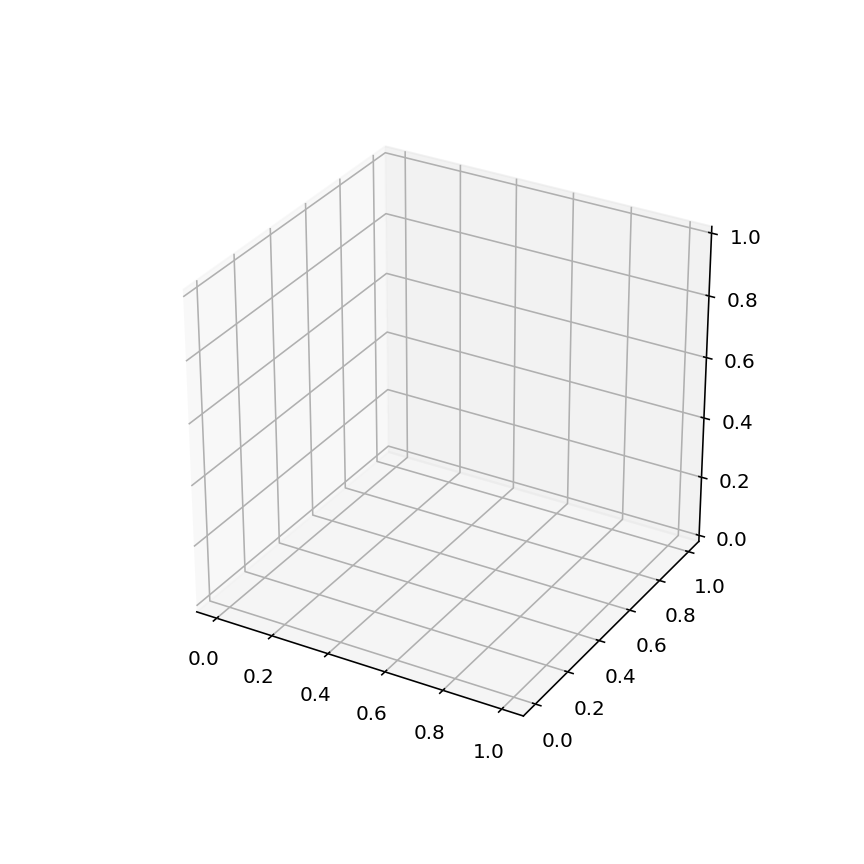

In [39]:
%matplotlib notebook
xs,ys,zs = rres
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, marker='o', alpha=0.3, s=1)
plt.show()

In [ ]:
nrrd.read(dataPath + '008/case.nrrd')[0].shape

In [ ]:
200*78*1*200

In [ ]:
160* 160* 48

In [ ]:
loadCases('train.txt')

In [ ]:
a=np.arange(9).reshape((3,3,1))
a

In [ ]:
labels = nrrd.read(dataPath + '008/needles.nrrd')[0]